In [1]:
from dataset import PairedDatasetSingle
pd = PairedDatasetSingle('In/0', 'Out_New', 0)

Length of x_train files: 943
Length of y_train files: 943
Length of keys: 943
Item 0 with max: 3482 and min: -2180
Normalized item 0 with max: 1.0 and min: 0.0
Item 1 with max: 1681 and min: -1108
Normalized item 1 with max: 1.0 and min: 0.0
Item 2 with max: 5660 and min: -2212
Normalized item 2 with max: 1.0 and min: 0.0
Item 3 with max: 3564 and min: -1221
Normalized item 3 with max: 1.0 and min: 0.0
Item 4 with max: 3452 and min: -2218
Normalized item 4 with max: 1.0 and min: 0.0
Item 5 with max: 3378 and min: -2213
Normalized item 5 with max: 1.0 and min: 0.0
Item 6 with max: 3744 and min: -2186
Normalized item 6 with max: 1.0 and min: 0.0
Item 7 with max: 3495 and min: -2201
Normalized item 7 with max: 1.0 and min: 0.0
Item 8 with max: 1730 and min: -1078
Normalized item 8 with max: 1.0 and min: 0.0
Item 9 with max: 3420 and min: -1118
Normalized item 9 with max: 1.0 and min: 0.0
Item 10 with max: 3547 and min: -2167
Normalized item 10 with max: 1.0 and min: 0.0
Item 11 with max: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
import os

# Model reconstruction from JSON file
with open('model_arch.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weights.h5')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


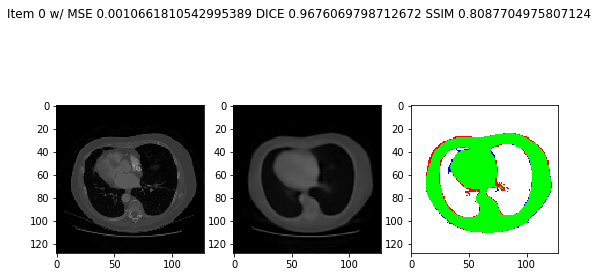

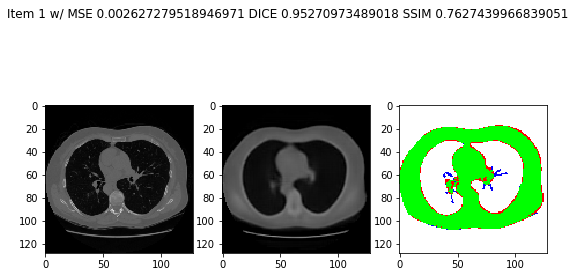

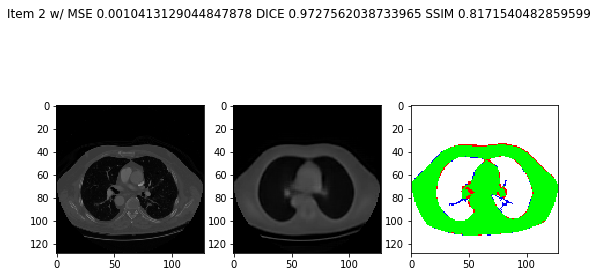

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


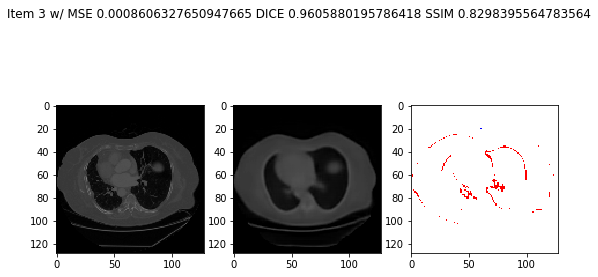

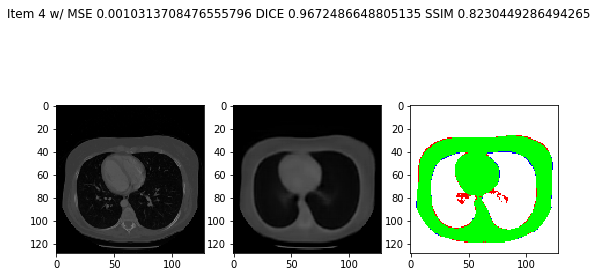

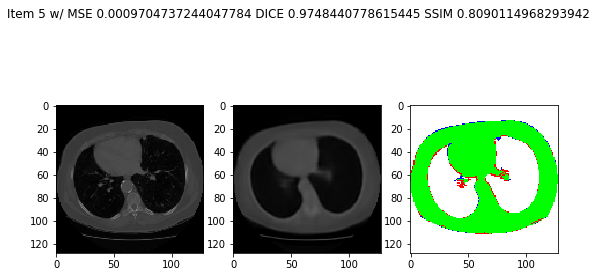

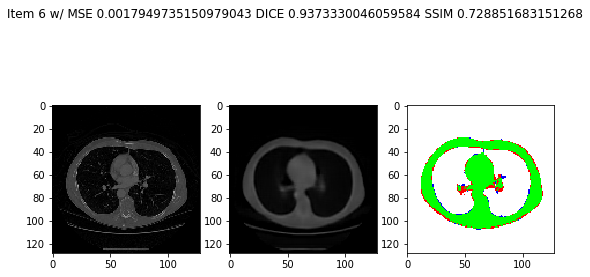

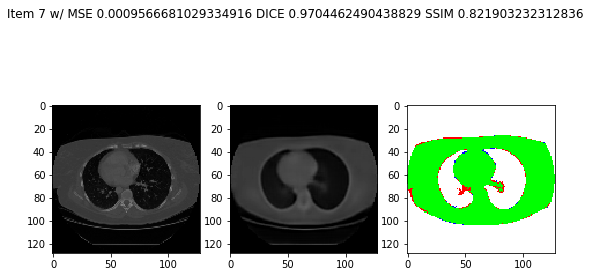

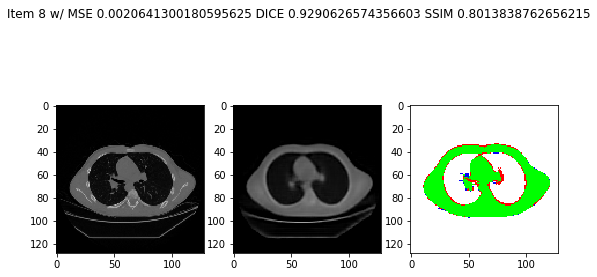

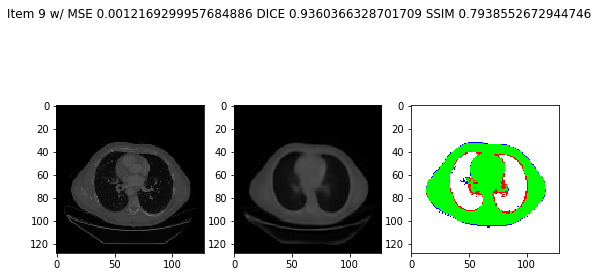

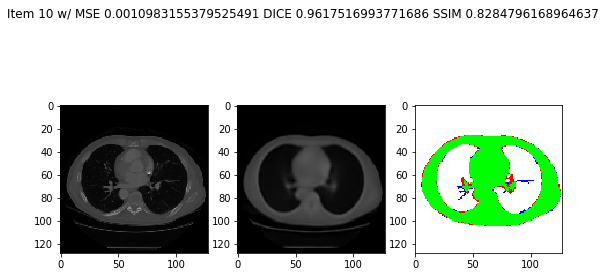

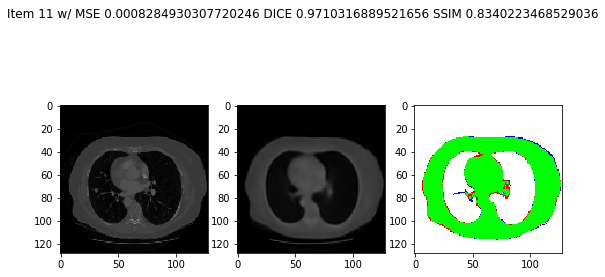

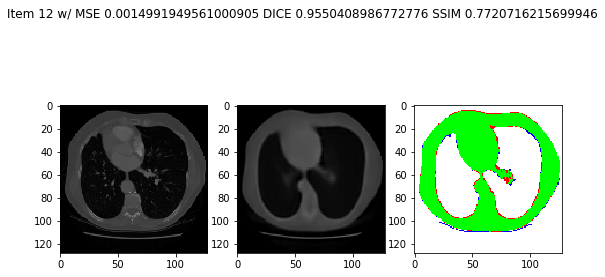

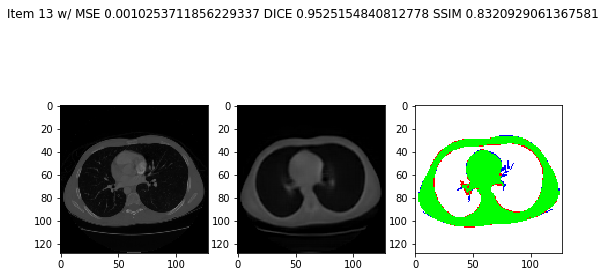

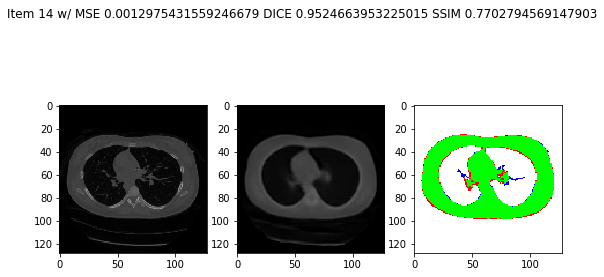

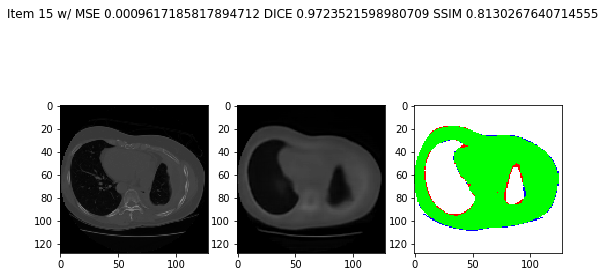

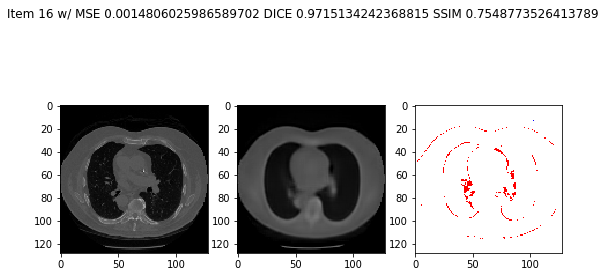

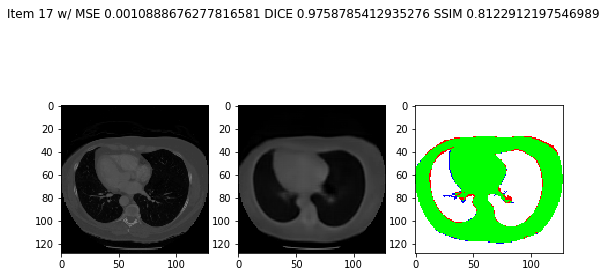

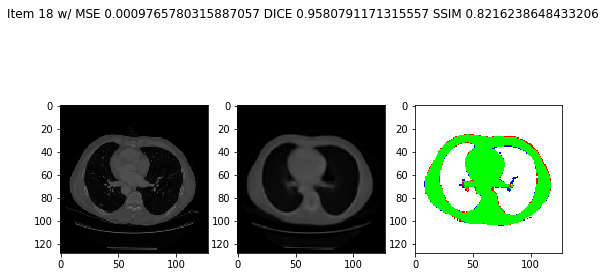

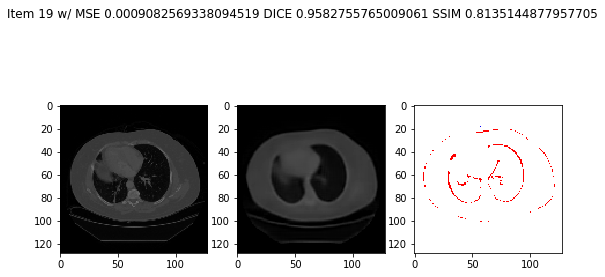

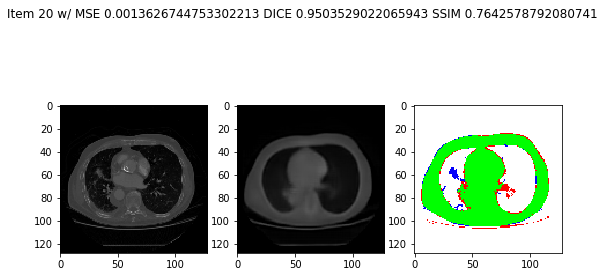

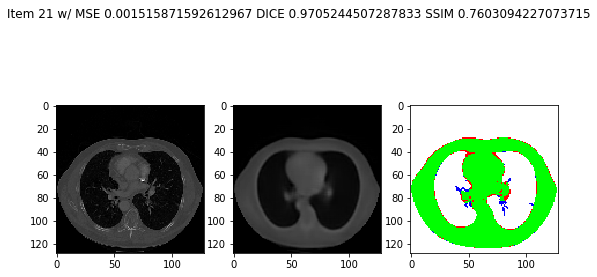

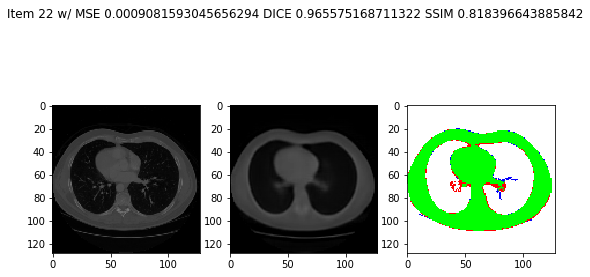

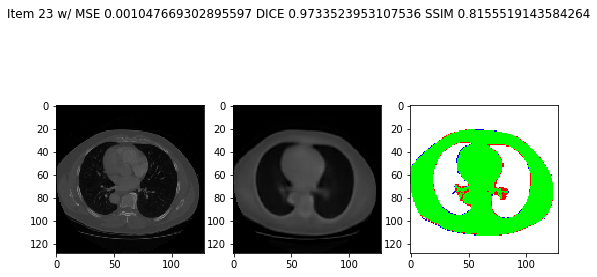

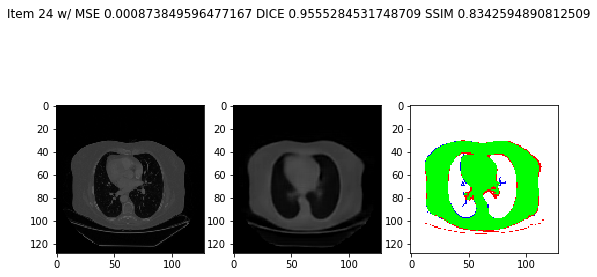

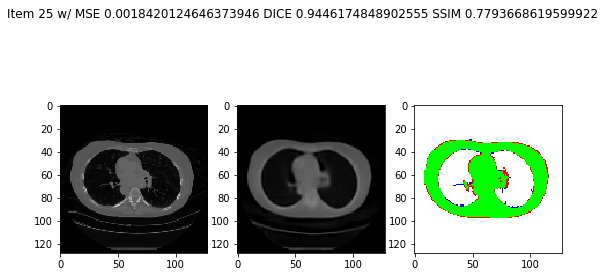

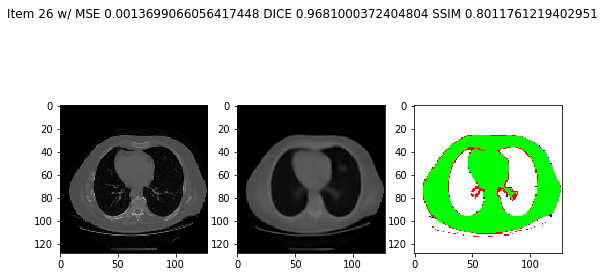

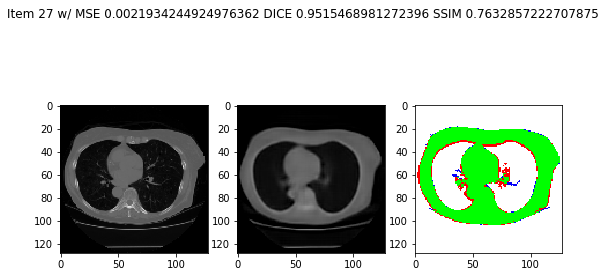

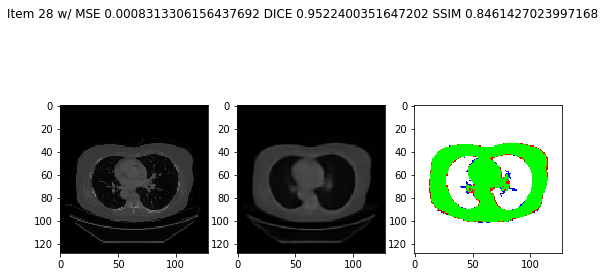

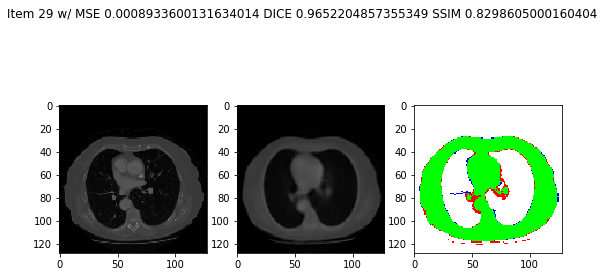

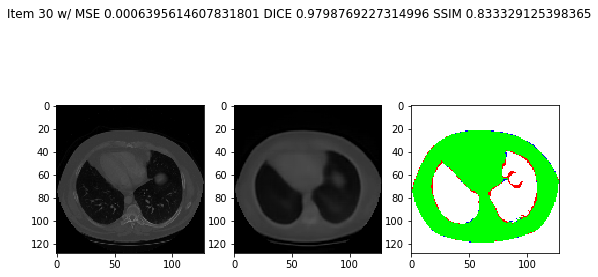

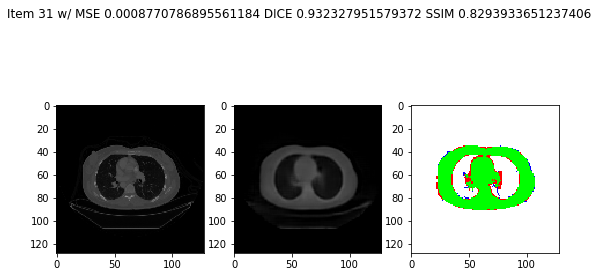

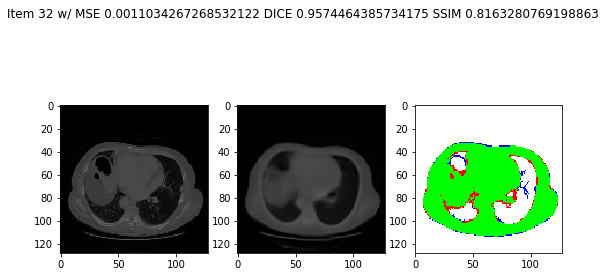

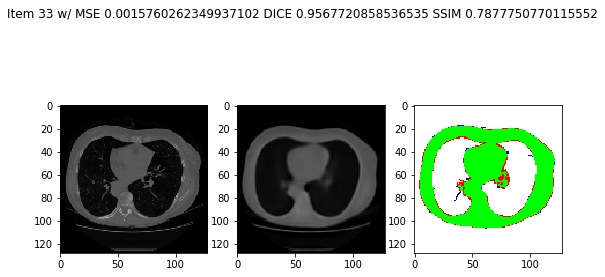

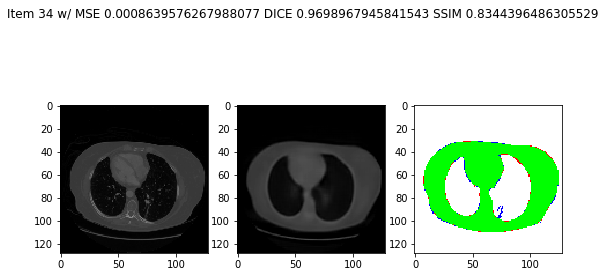

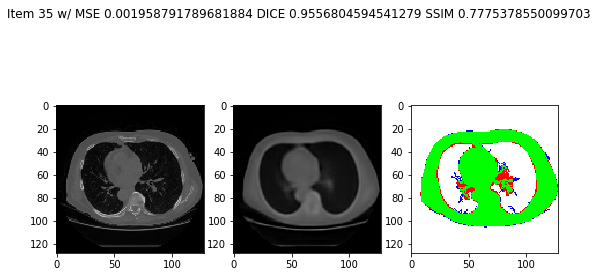

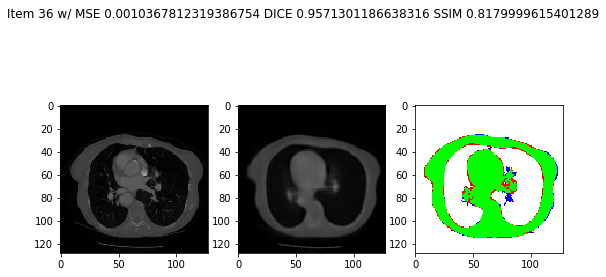

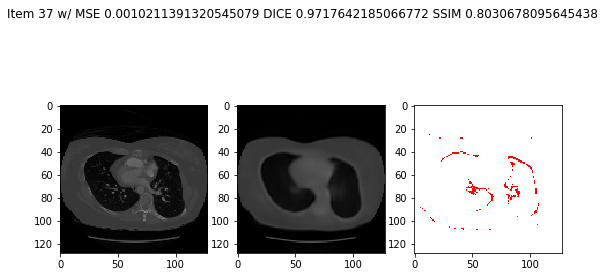

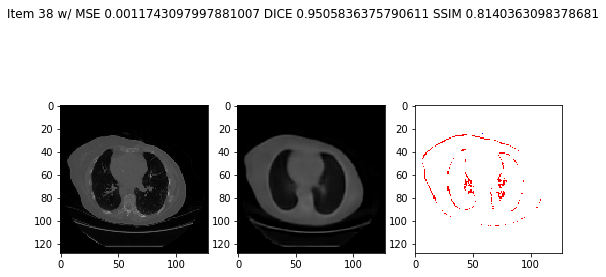

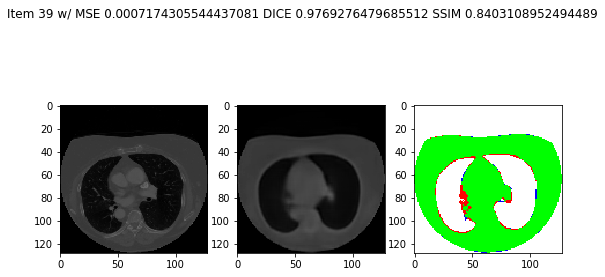

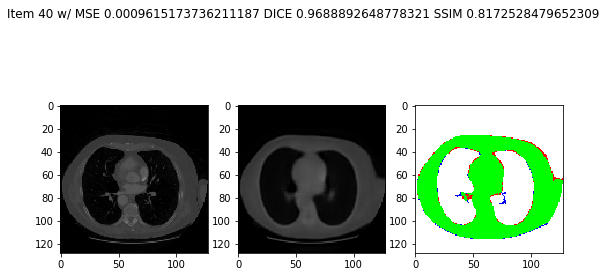

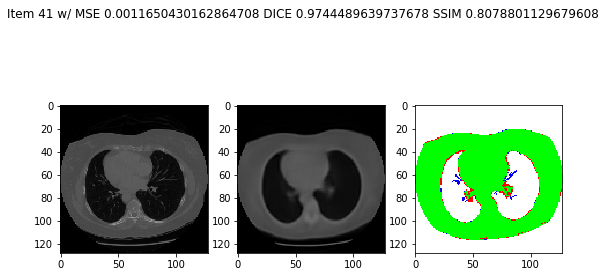

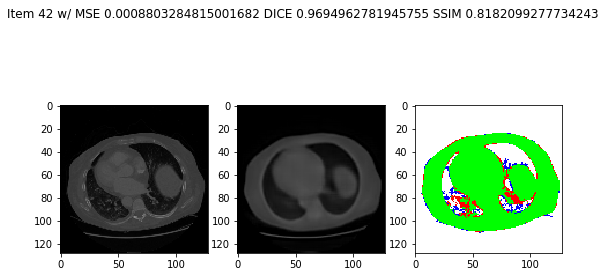

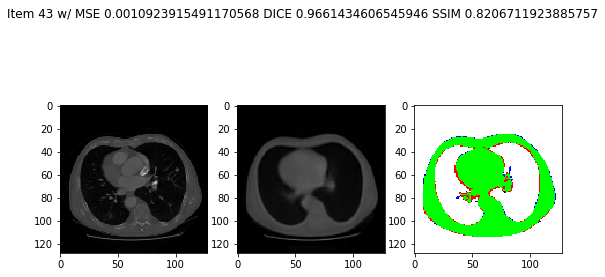

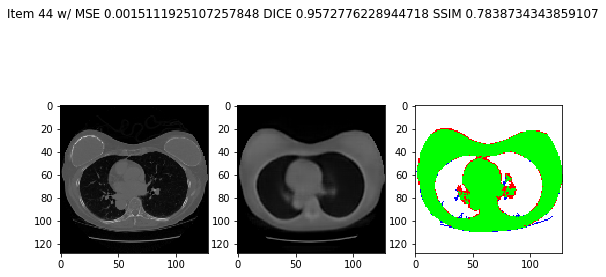

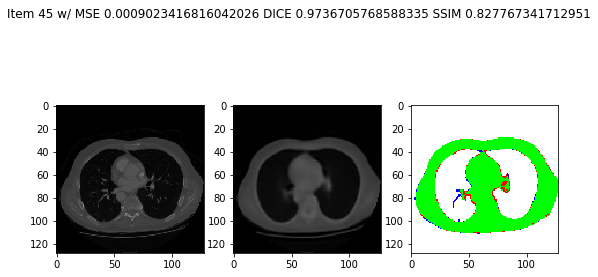

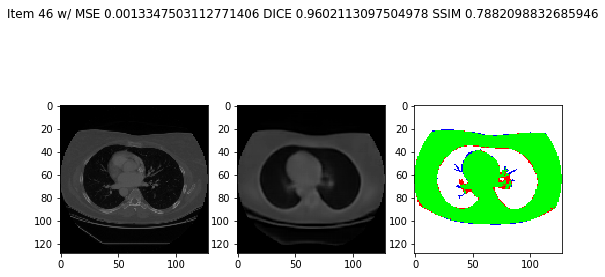

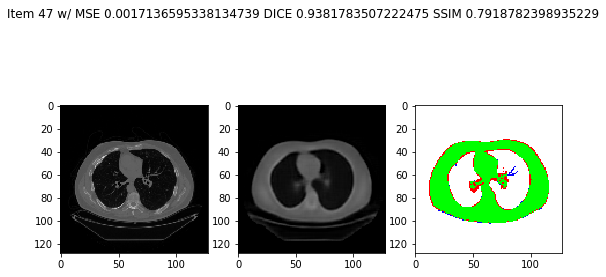

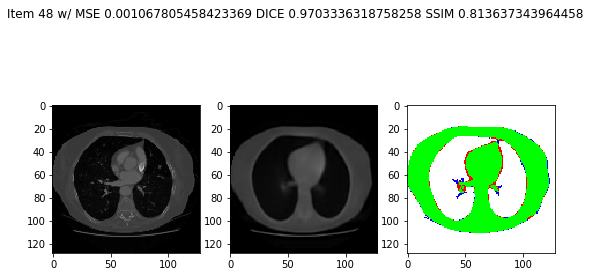

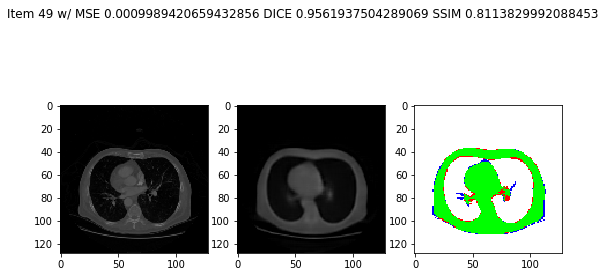

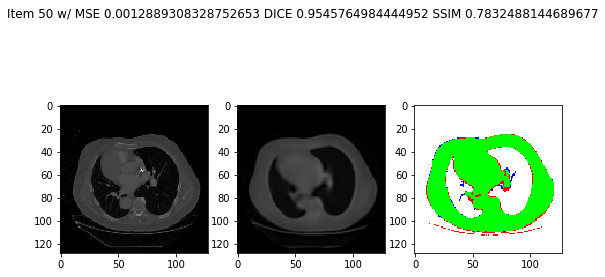

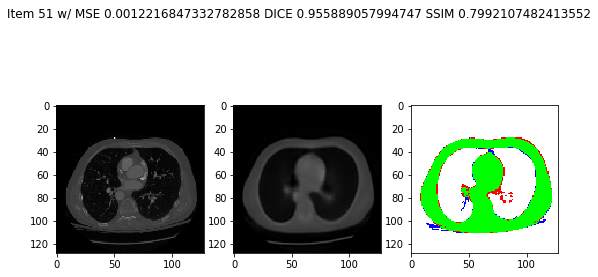

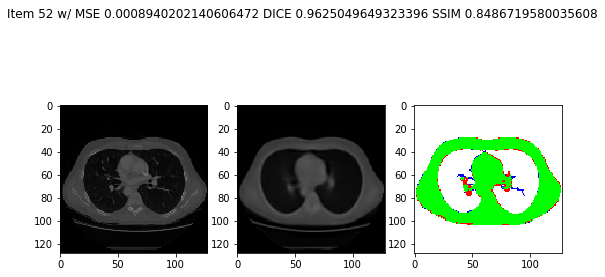

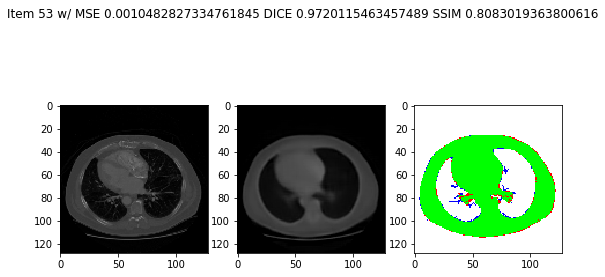

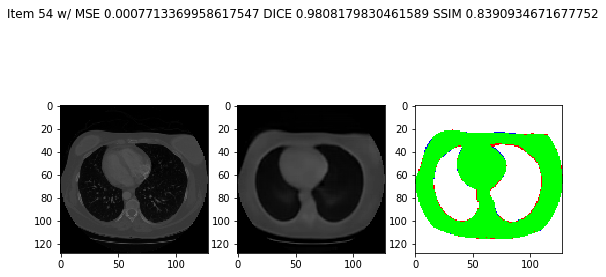

KeyboardInterrupt: 

In [5]:

    
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity
import cv2 as cv
import numpy.ma as ma

def dice_score(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.1, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask

def extract_lung_mask(volume, size = 128):

    slices = []

    for i in range(0, size):

        masked_slice = extract_slice_mask(volume[i])
        slices.append(masked_slice)

    slices = np.array(slices)
    return slices

def tpfp(truth, prediction):

    h, w, l = truth.shape[0], truth.shape[1], truth.shape[2]

    tp = np.zeros(truth.shape)
    fp = np.zeros(truth.shape)
    fn = np.zeros(truth.shape)
    tn = np.zeros(truth.shape)

    truth_mask = extract_lung_mask(truth)
    pred_mask = extract_lung_mask(prediction)

    for i in range(0, h):

        for j in range(0, w):

            for k in range(0, l):

                if (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 1):

                    tp[i, j, k] = 1

                elif (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 0):

                    fn[i, j, k] = 1

                elif (truth_mask[i, j, k] == 0 and pred_mask[i, j, k] == 1):

                    fp[i, j, k] = 1

                else:

                    tn[i, j, k] = 1

    tp = ma.masked_values(tp * 100, 0)
    fp = ma.masked_values(fp * 50, 0)
    fn = ma.masked_values(fn, 0)
    
    prdd = pred_mask[64]
    trdd = truth_mask[64]

    #dice = np.sum(prdd[trdd==1])*2.0 / (np.sum(prdd) + np.sum(trdd))
    dice = dice_score(truth_mask, pred_mask)
    return tp, fp, fn, dice

mses = []
ssims = []
dices = []

for i in range(0, 943):
        
    original = np.reshape(pd.y_train[i], (128, 128, 128))
    input_1 = np.reshape(pd.x_train[i], (1, 1024, 1024, 1))
    output_1 = np.reshape(model.predict(input_1), (128, 128, 128))
    
    mse = mean_squared_error(original, output_1)
    ssim = structural_similarity(original, output_1, data_range = 1)
    
    tp, fp, fn, dice = tpfp(original, output_1)
    f = plt.figure(figsize = (9, 5))
    
    f.add_subplot(1, 3, 1)
    plt.imshow(original[64], cmap = 'gray', vmin = 0, vmax = 1)
    
    f.add_subplot(1, 3, 2)
    plt.imshow(output_1[64], cmap = 'gray', vmin = 0, vmax = 1)
    
    f.add_subplot(1, 3, 3)
    plt.imshow(tp[64], cmap = 'brg', vmin = 0.1) #green
    plt.imshow(fp[64], cmap = 'brg', vmin = 0.1, vmax = 100) #red
    plt.imshow(fn[64], cmap = 'brg', vmin = 0.1, vmax = 90) #blue
    
    mses.append(mse)
    ssims.append(ssim)
    dices.append(dice)
    
    plt.suptitle("Item {} w/ MSE {} DICE {} SSIM {}".format(i, mse, dice, ssim))
    plt.show(block = True)

In [6]:
from statistics import mean
print(mean(mses))
print(mean(dices))
print(mean(ssims))

0.0011900706052539642
0.9611571828756816
0.8068173427439007


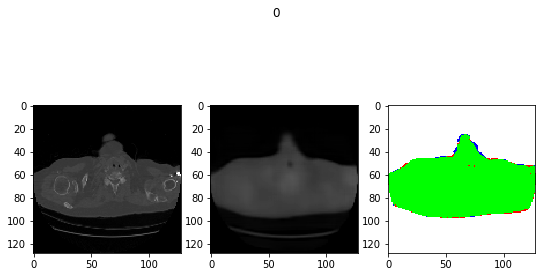

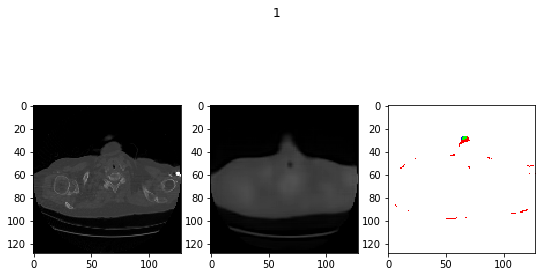

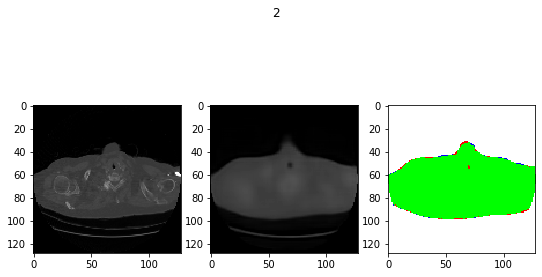

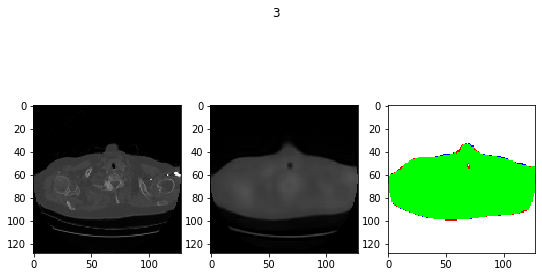

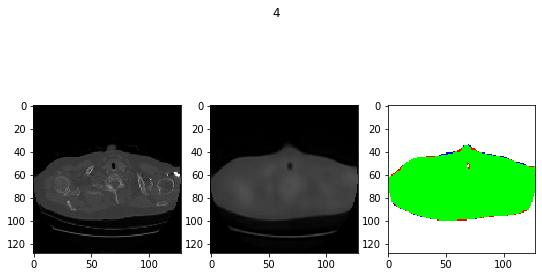

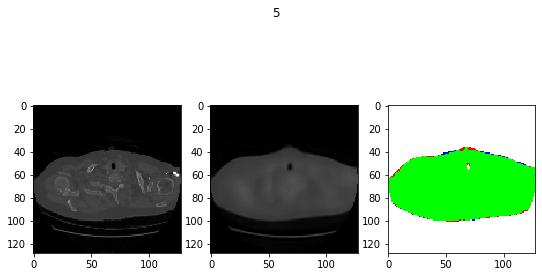

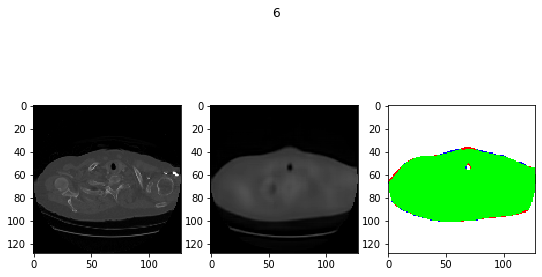

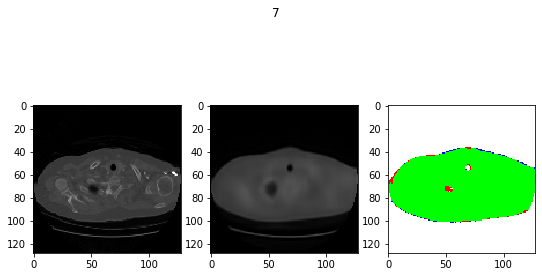

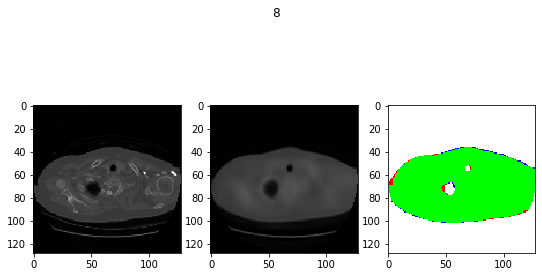

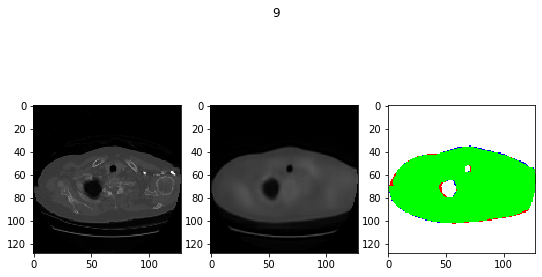

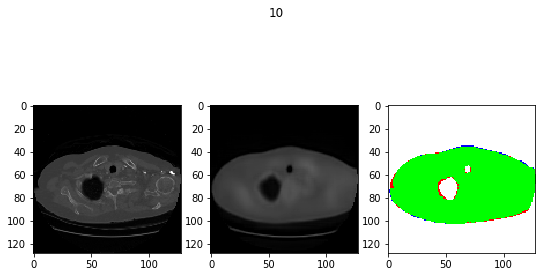

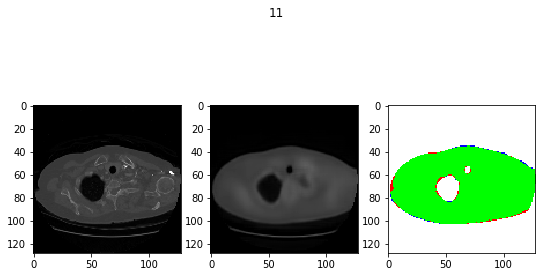

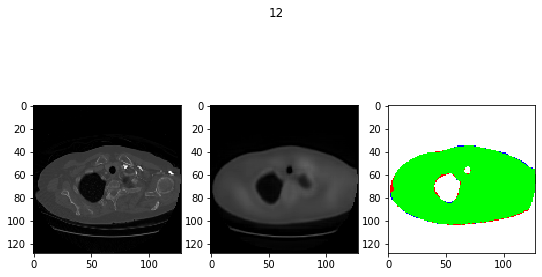

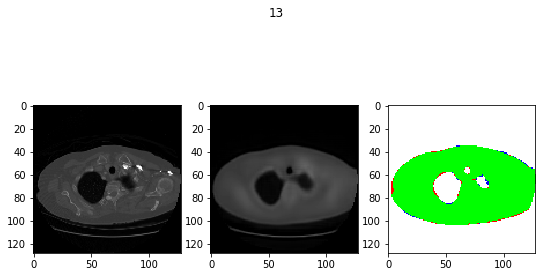

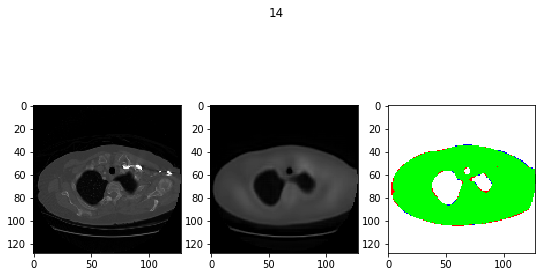

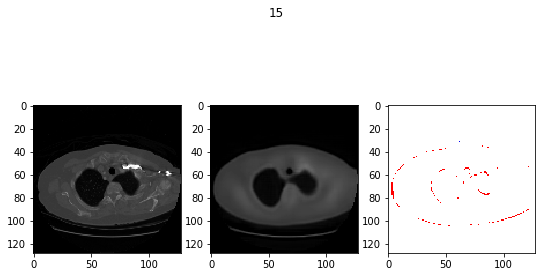

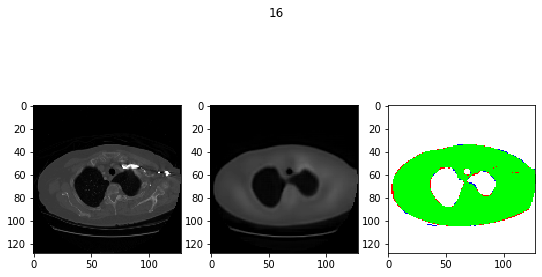

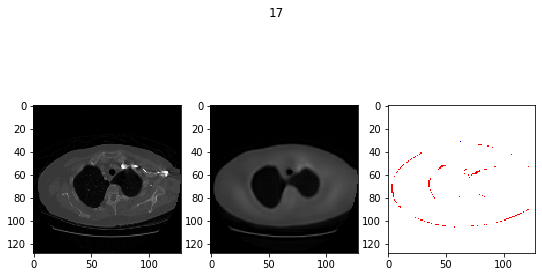

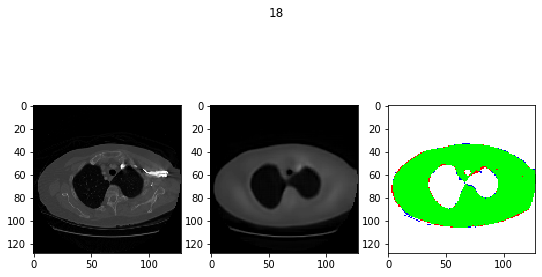

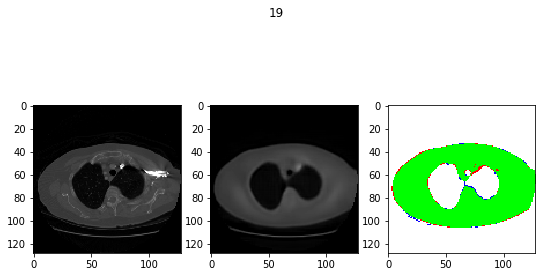

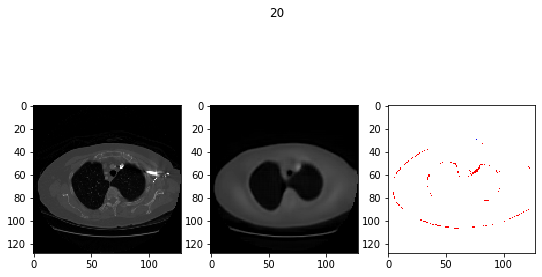

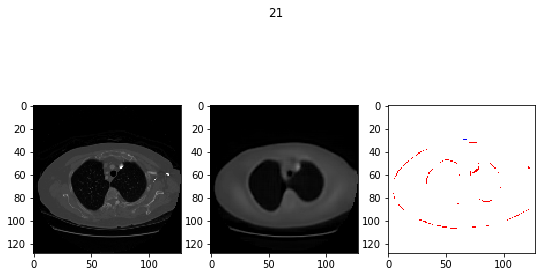

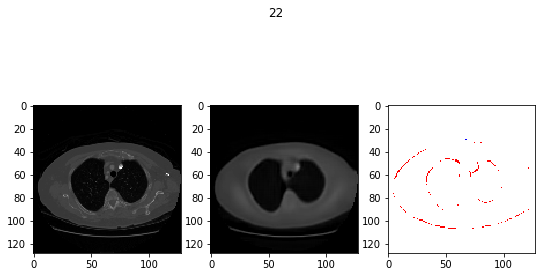

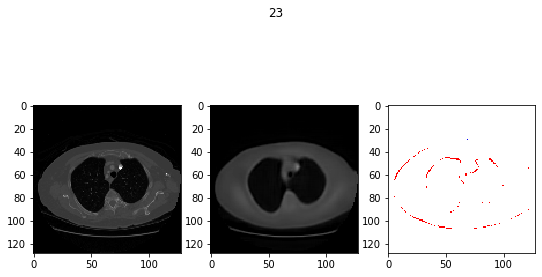

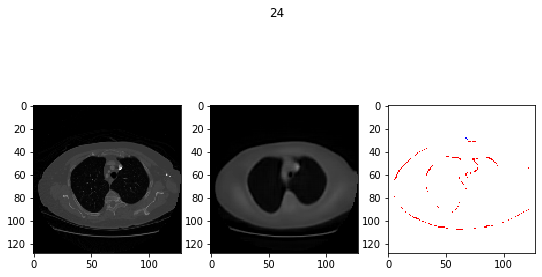

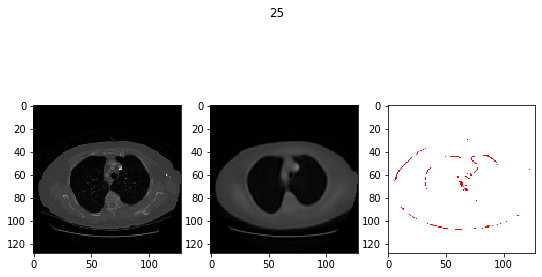

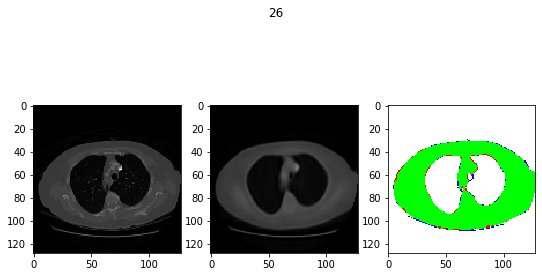

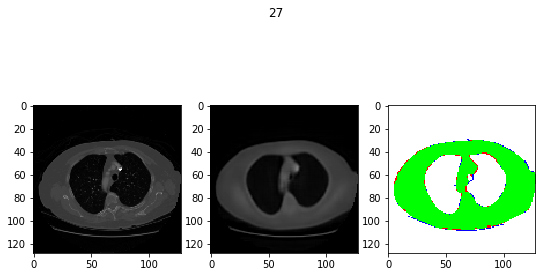

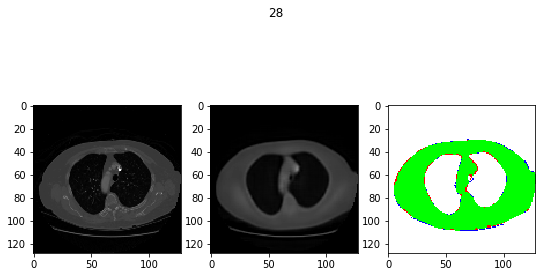

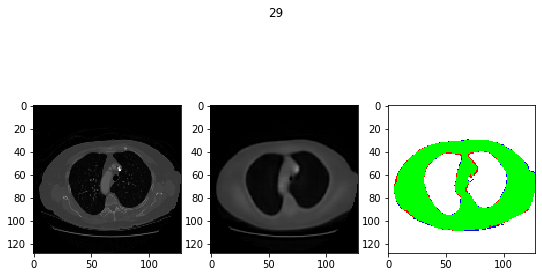

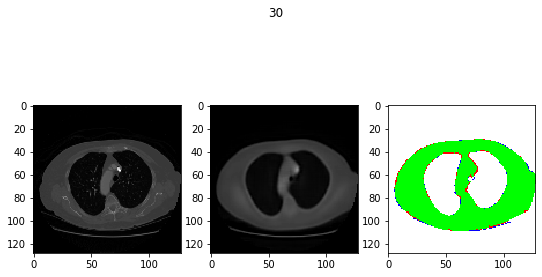

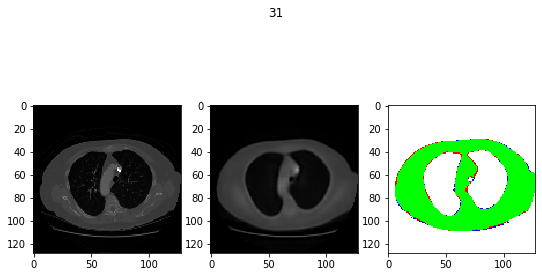

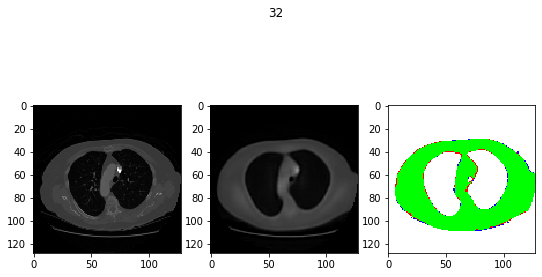

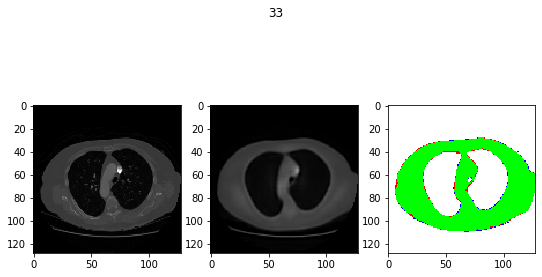

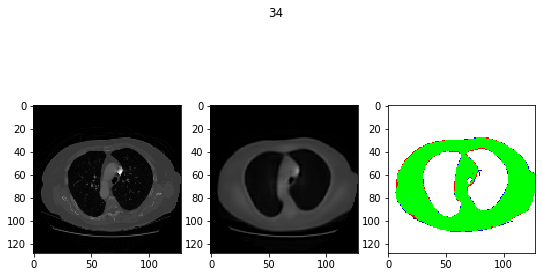

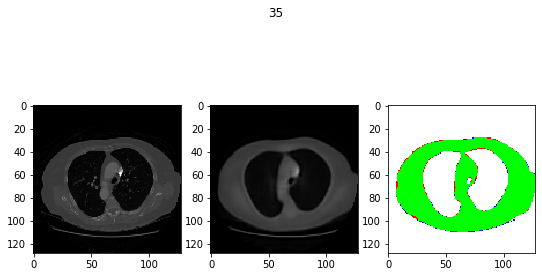

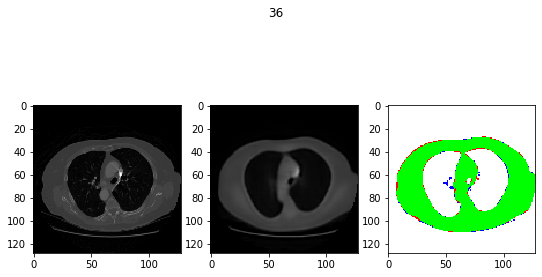

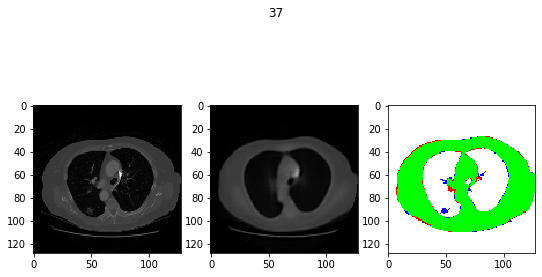

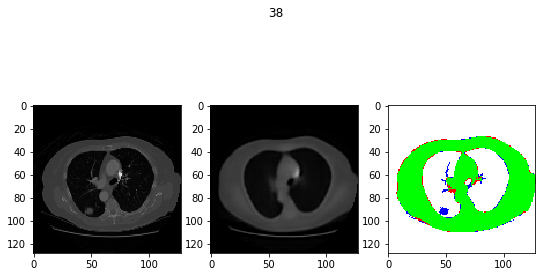

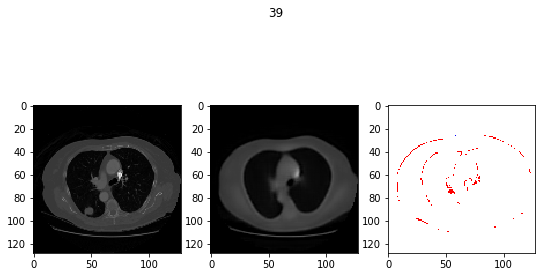

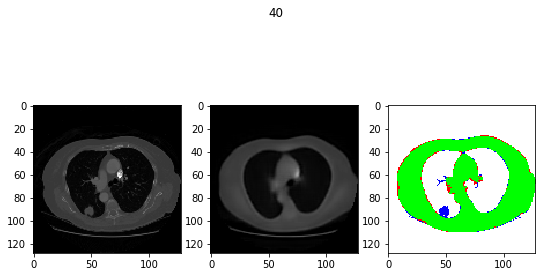

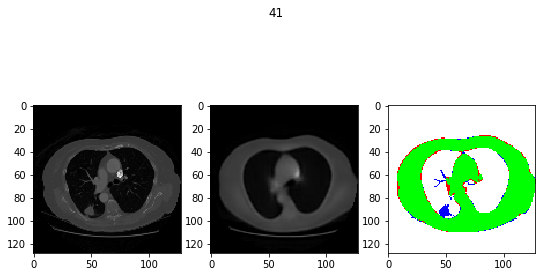

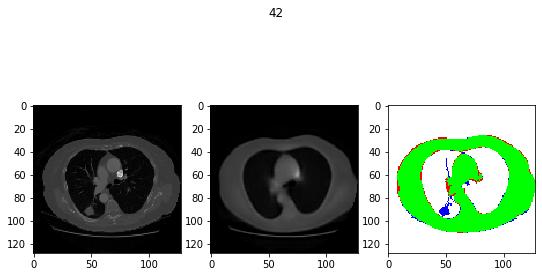

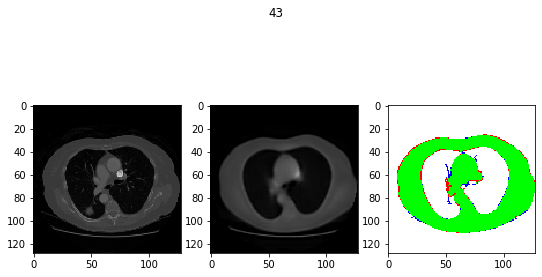

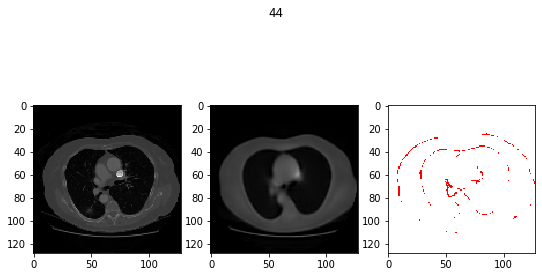

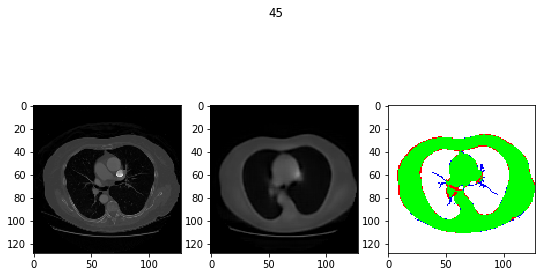

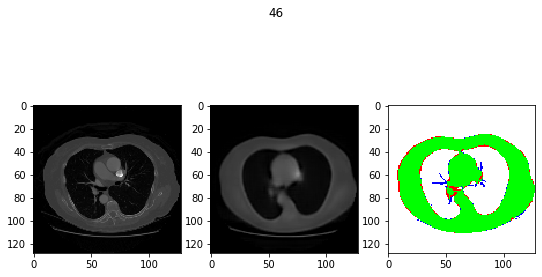

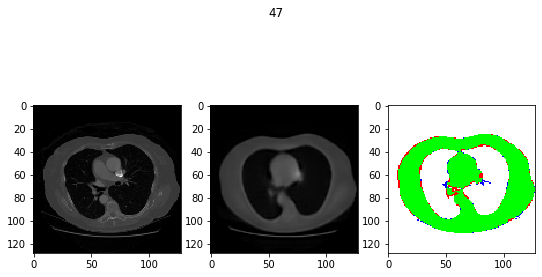

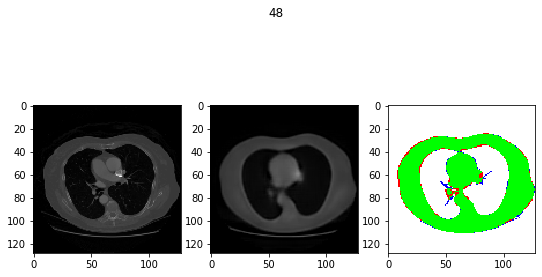

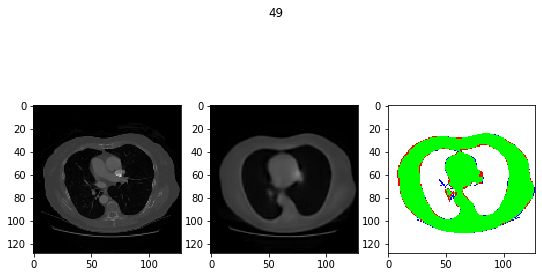

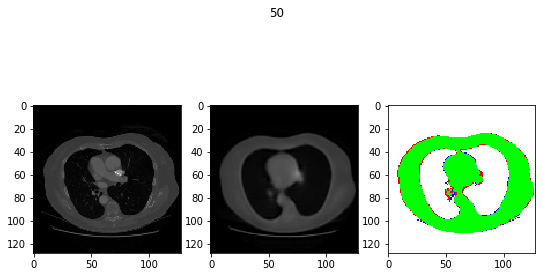

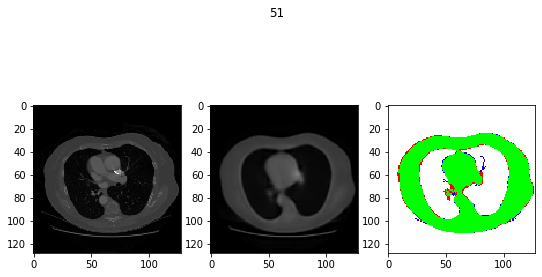

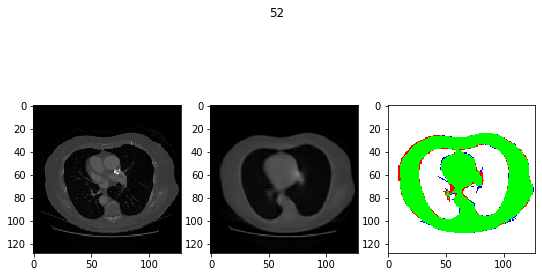

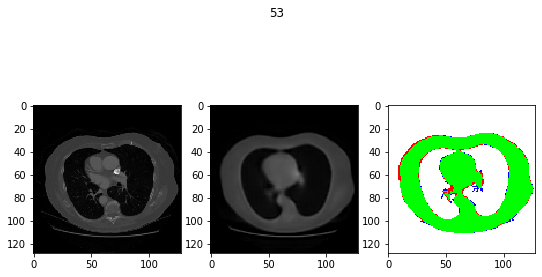

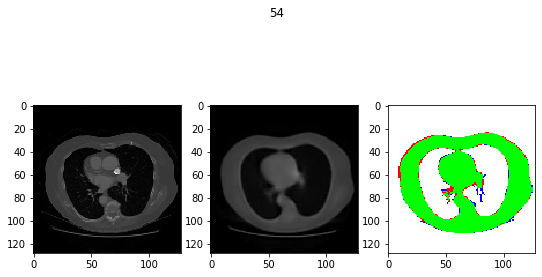

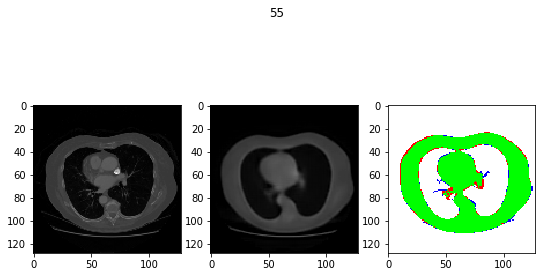

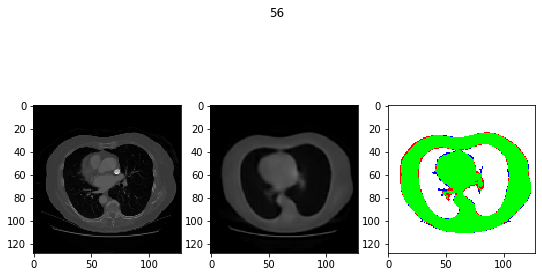

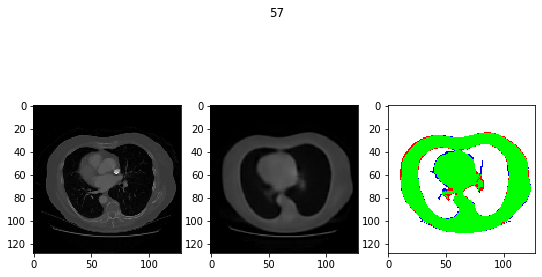

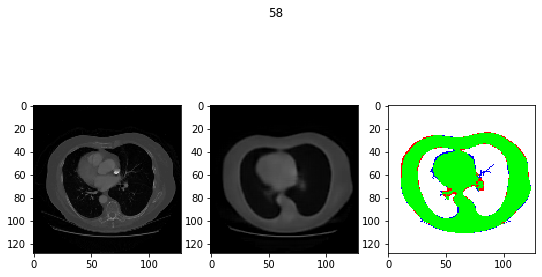

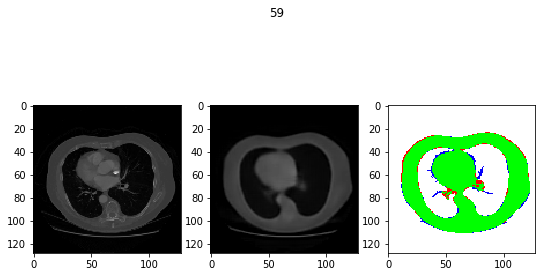

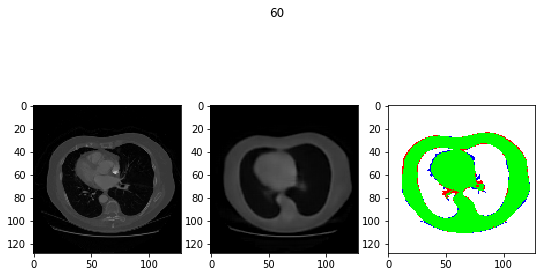

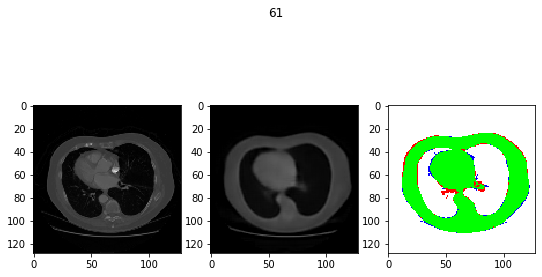

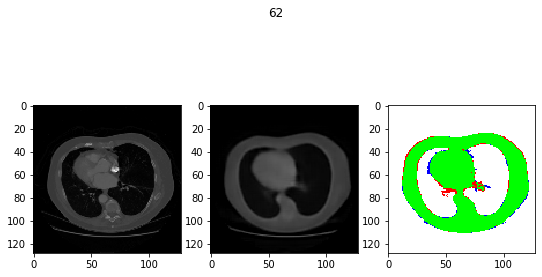

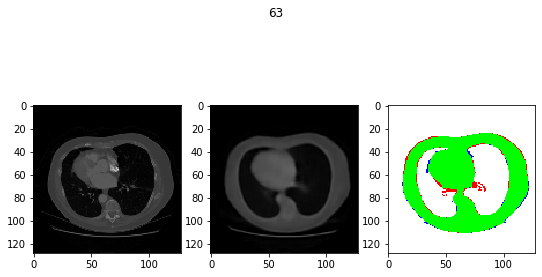

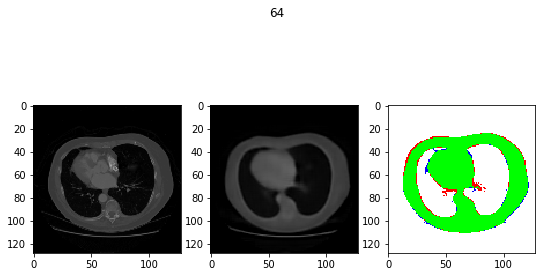

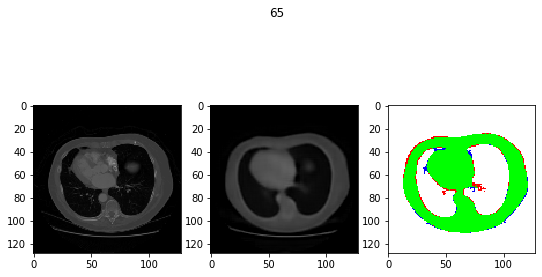

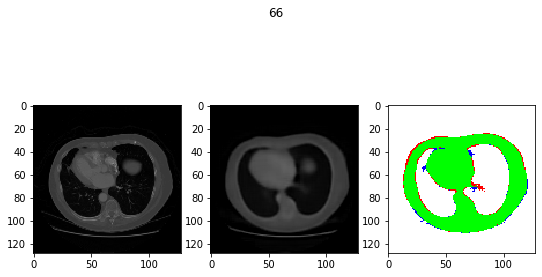

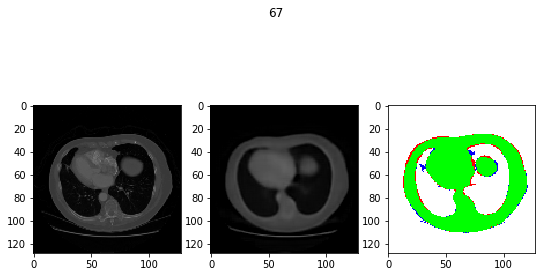

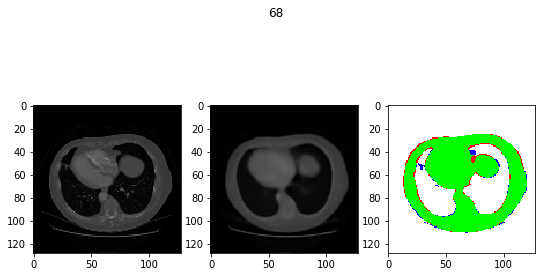

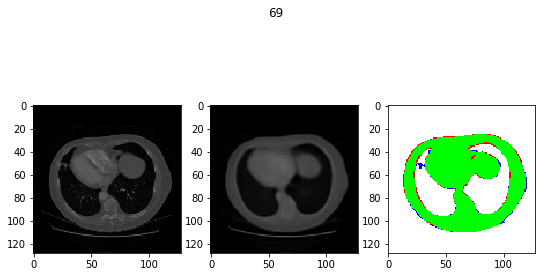

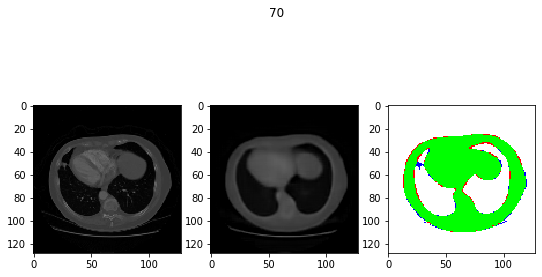

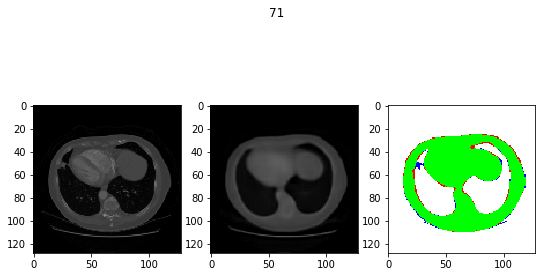

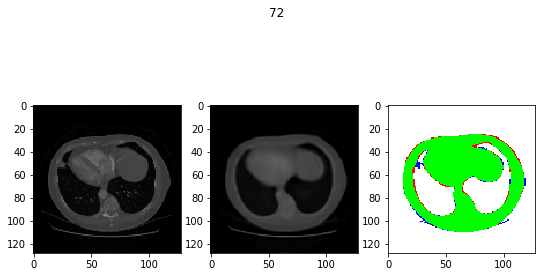

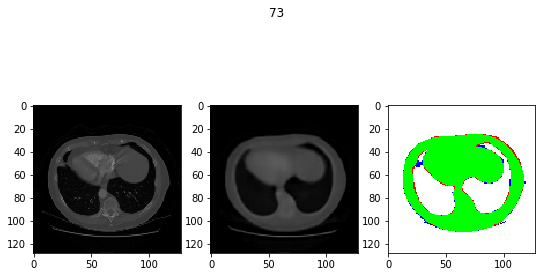

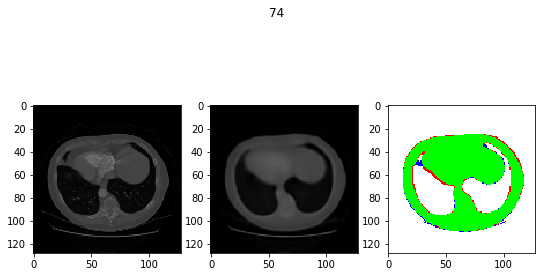

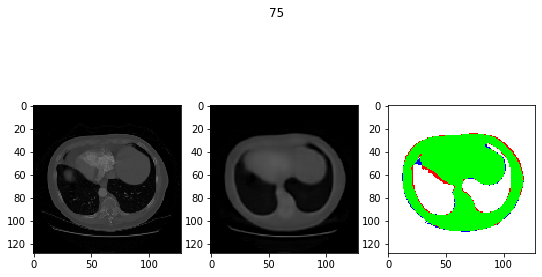

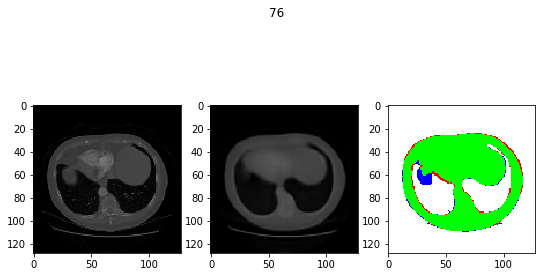

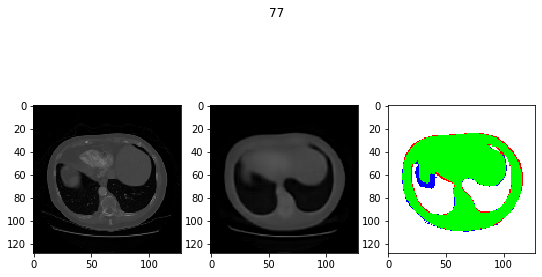

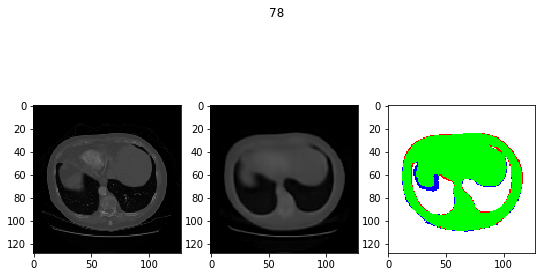

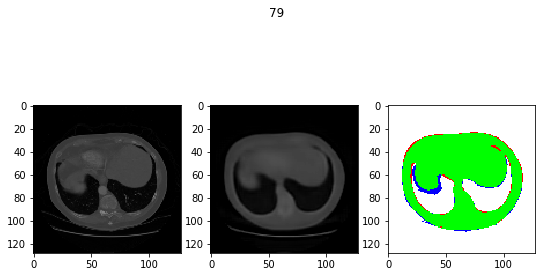

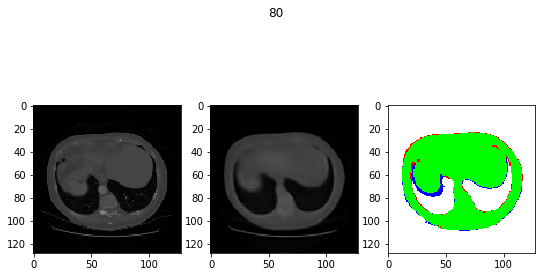

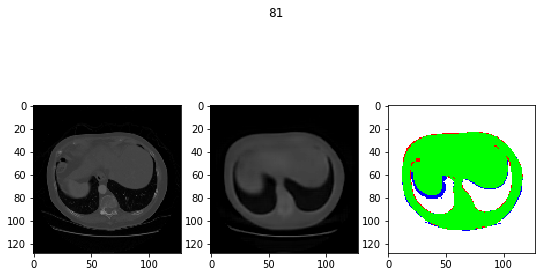

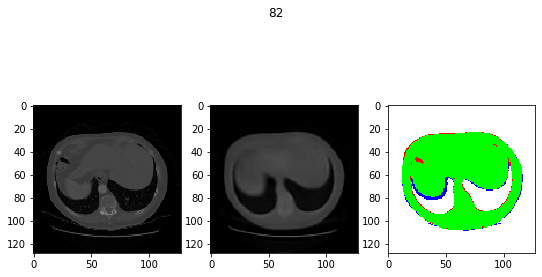

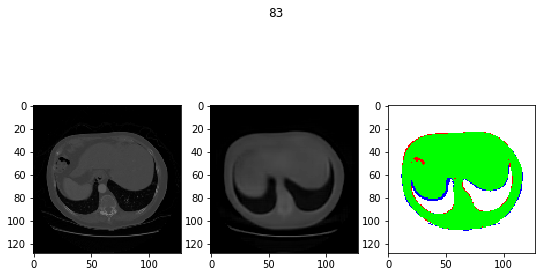

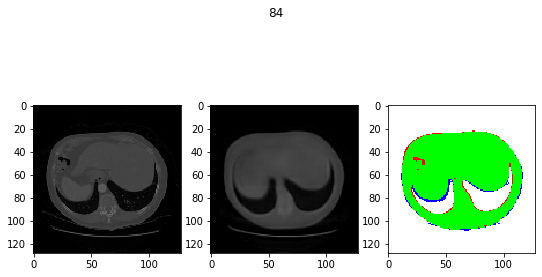

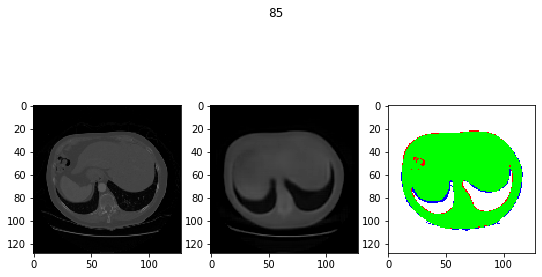

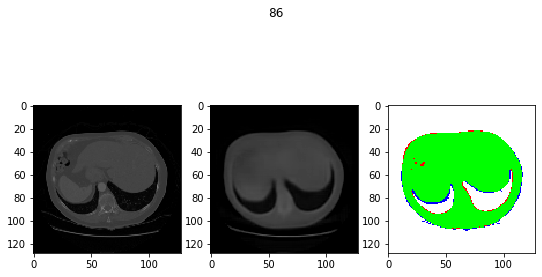

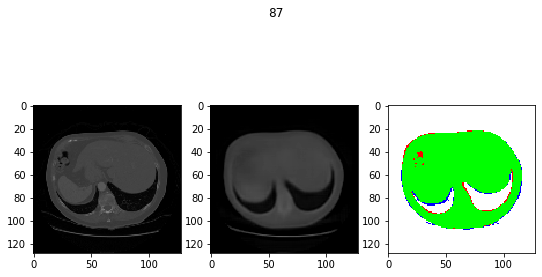

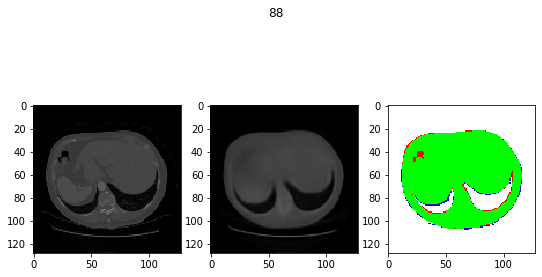

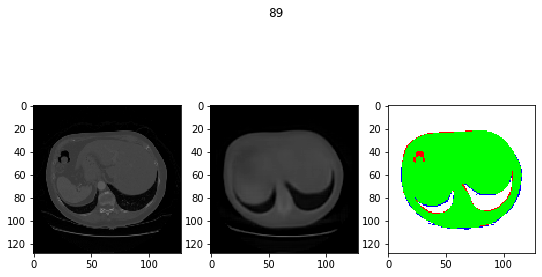

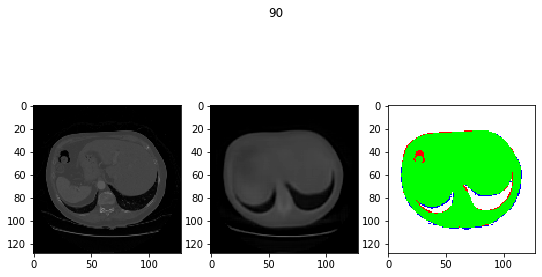

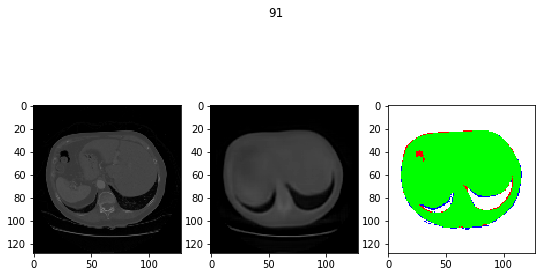

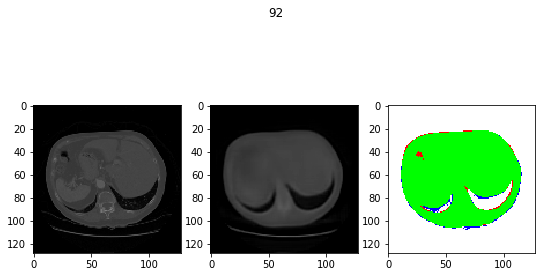

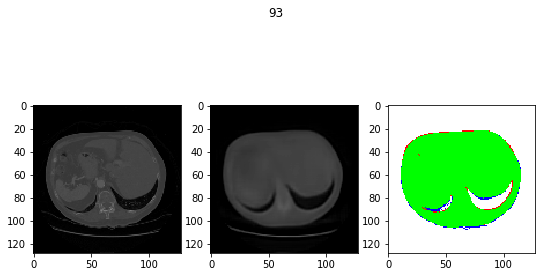

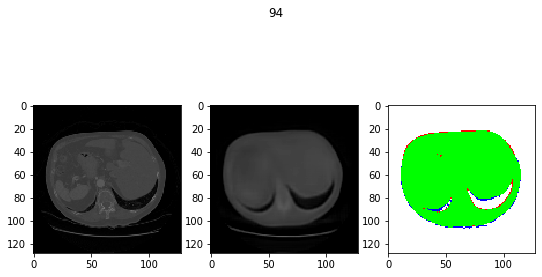

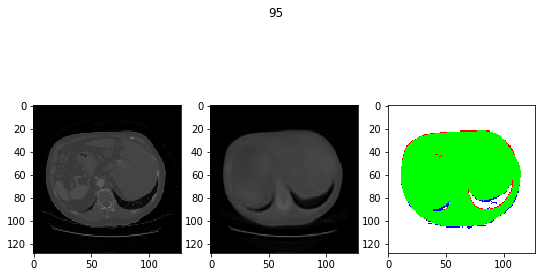

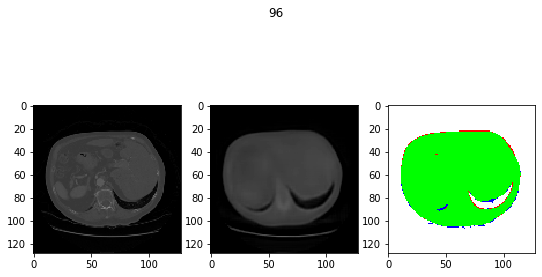

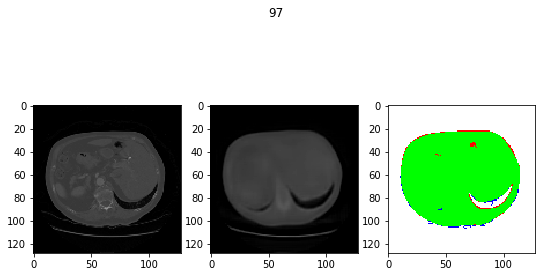

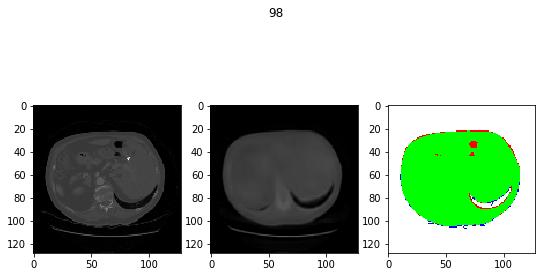

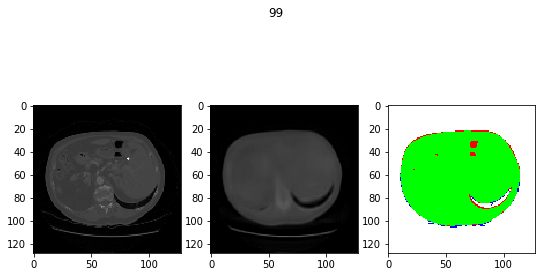

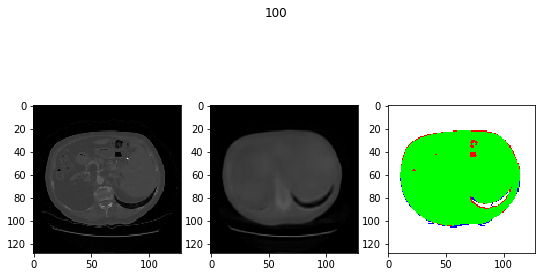

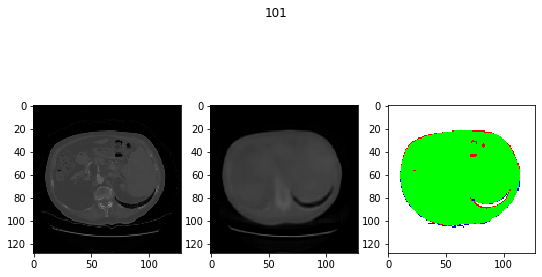

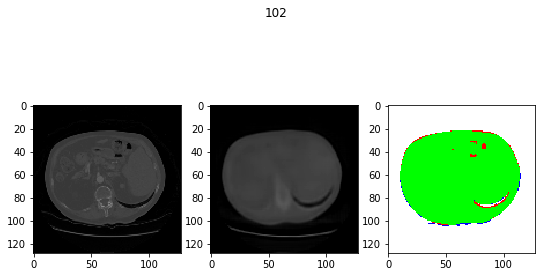

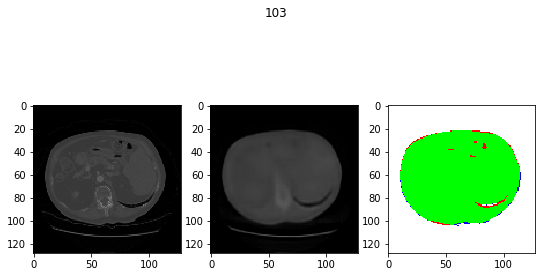

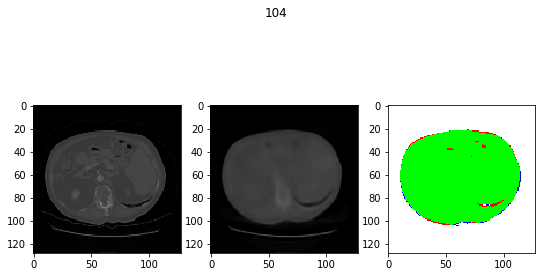

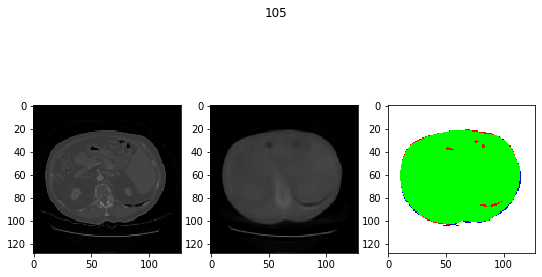

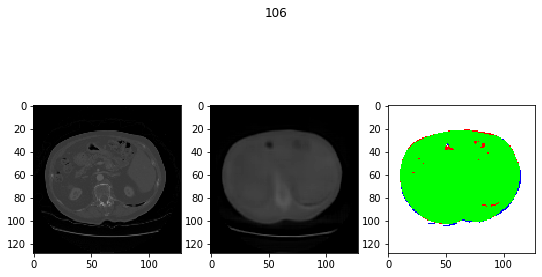

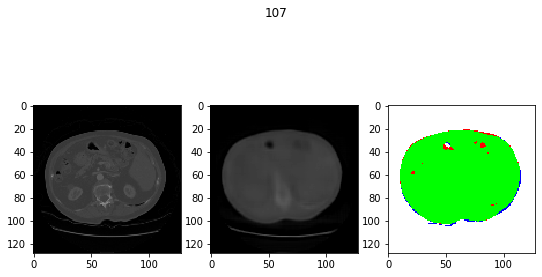

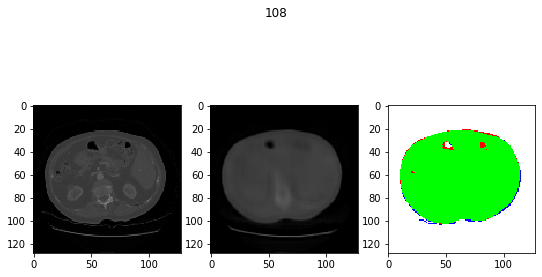

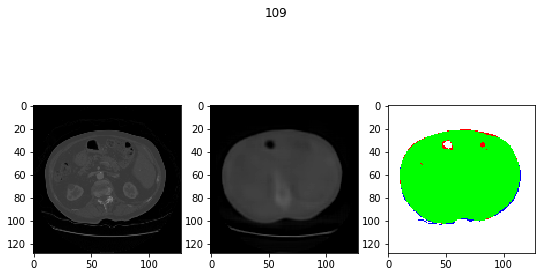

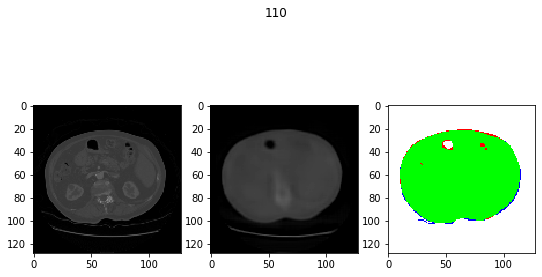

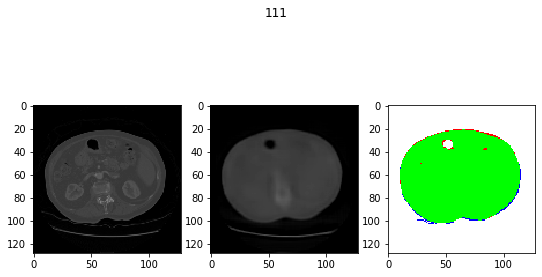

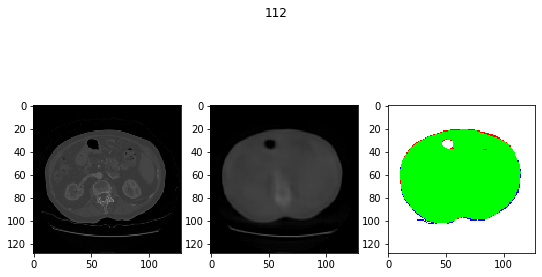

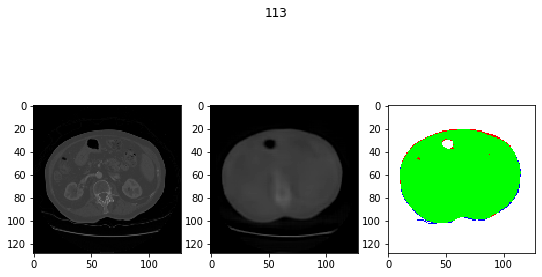

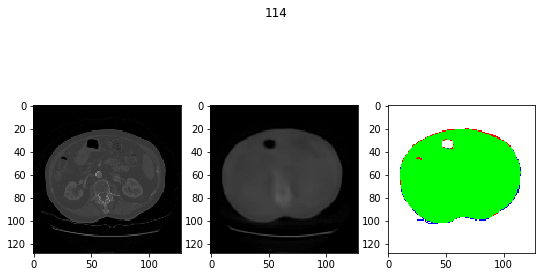

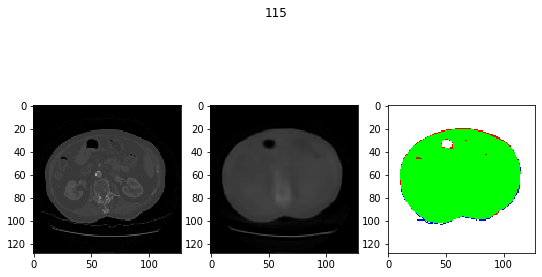

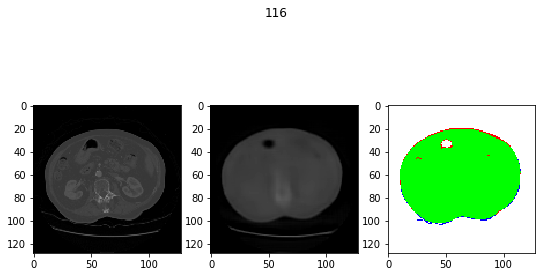

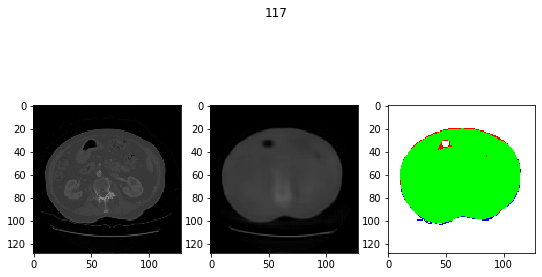

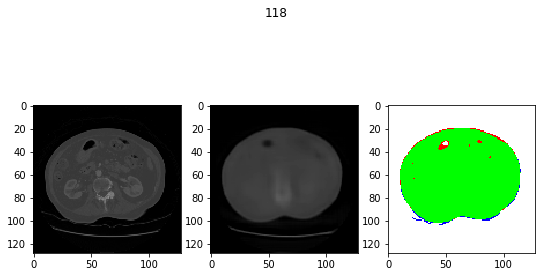

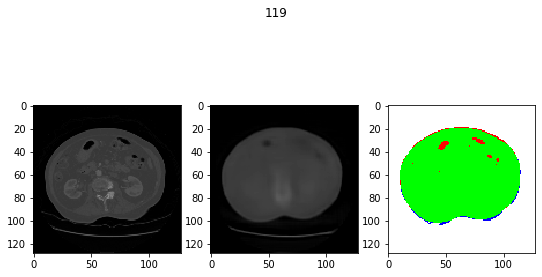

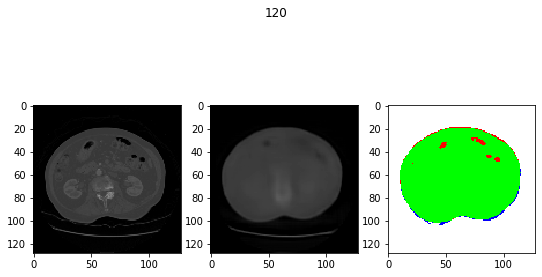

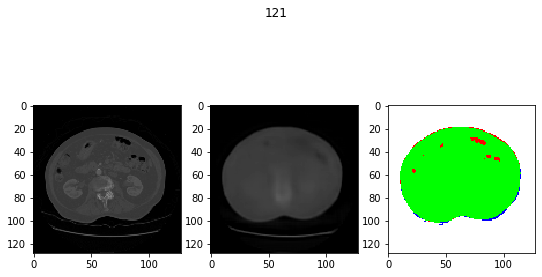

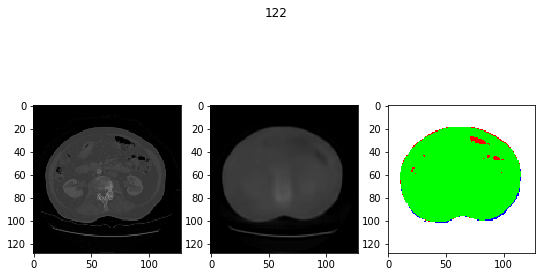

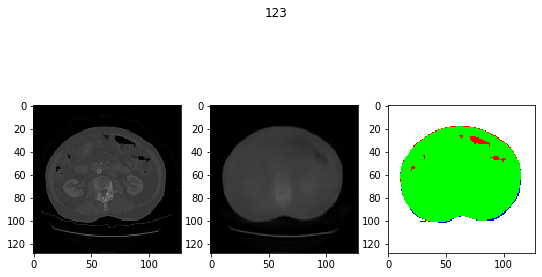

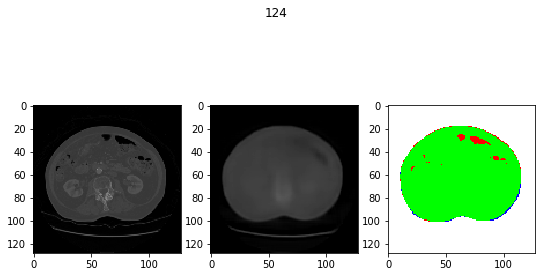

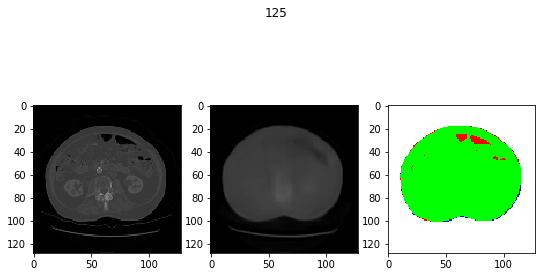

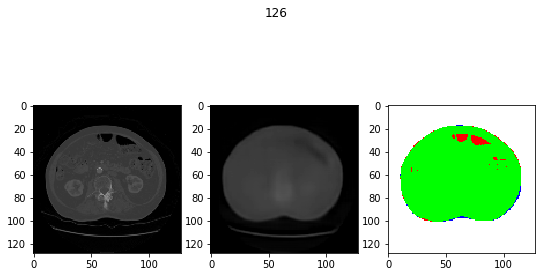

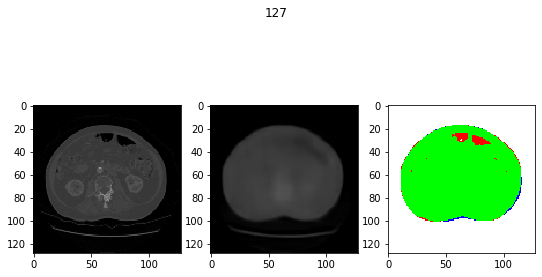

In [7]:
for i in range(0, 1):
    
    original = np.reshape(pd.y_train[i], (128, 128, 128))
    input_1 = np.reshape(pd.x_train[i], (1, 1024, 1024, 1))
    output_1 = np.reshape(model.predict(input_1), (128, 128, 128))
    
    tp, fp, fn, dice = tpfp(original, output_1)
    
    for k in range(0, 128):
        f = plt.figure(figsize = (9, 5))

        f.add_subplot(1, 3, 1)
        plt.imshow(original[k], cmap = 'gray', vmin = 0, vmax = 1)

        f.add_subplot(1, 3, 2)
        plt.imshow(output_1[k], cmap = 'gray', vmin = 0, vmax = 1)

        f.add_subplot(1, 3, 3)
        plt.imshow(tp[k], cmap = 'brg', vmin = 0.1) #green
        plt.imshow(fp[k], cmap = 'brg', vmin = 0.1, vmax = 100) #red
        plt.imshow(fn[k], cmap = 'brg', vmin = 0.1, vmax = 90) #blue


        plt.suptitle(k)
        plt.show(block = True)

In [8]:
import os
import boto3

bucketname = 'pennsingle'
s3_client = boto3.client('s3')

for pt in os.listdir('Results_1024_0'):
    
    response = s3_client.upload_file(os.path.join('Results_1024_0', pt), bucketname, os.path.join('Results_1024_0', pt))
    print(os.path.join('Results_1024_0', pt))
    

Results_1024_0/502.npy
Results_1024_0/122.npy
Results_1024_0/237.npy
Results_1024_0/805.npy
Results_1024_0/842.npy
Results_1024_0/407.npy
Results_1024_0/147.npy
Results_1024_0/707.npy
Results_1024_0/708.npy
Results_1024_0/408.npy
Results_1024_0/334.npy
Results_1024_0/463.npy
Results_1024_0/589.npy
Results_1024_0/23.npy
Results_1024_0/539.npy
Results_1024_0/551.npy
Results_1024_0/514.npy
Results_1024_0/441.npy
Results_1024_0/840.npy
Results_1024_0/747.npy
Results_1024_0/169.npy
Results_1024_0/400.npy
Results_1024_0/11.npy
Results_1024_0/719.npy
Results_1024_0/832.npy
Results_1024_0/900.npy
Results_1024_0/315.npy
Results_1024_0/873.npy
Results_1024_0/674.npy
Results_1024_0/829.npy
Results_1024_0/234.npy
Results_1024_0/638.npy
Results_1024_0/454.npy
Results_1024_0/385.npy
Results_1024_0/410.npy
Results_1024_0/577.npy
Results_1024_0/389.npy
Results_1024_0/690.npy
Results_1024_0/798.npy
Results_1024_0/151.npy
Results_1024_0/33.npy
Results_1024_0/372.npy
Results_1024_0/292.npy
Results_1024_0